## About exp
- seed 1010
- feature enginiering
- w2v

## Library

In [1]:
# library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import lightgbm as lgb

from tqdm import tqdm_notebook as tqdm

from gensim.models import word2vec, KeyedVectors
import pycld2 as cld2

import warnings
warnings.filterwarnings('ignore')

/Users/kazuki/.pyenv/versions/anaconda3-2020.02/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


## Config

In [2]:
# Config
SEED = 1010
SHUFFLE = True
N_SPLITS = 5
TRAIN = True

EXP = '007'

LGBM_PARAMS = {
    'num_leaves': 200,
    'max_bin':350,
    'objective': 'regression',
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'random_state': SEED,
    'metric':"rmse",
}

LGBM_FIT_PARAMS = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 50,
    'verbose_eval': 100,
}

In [3]:
def train_lgbm(X_train, y_train, X_valid, y_valid, X_test, categorical_features, fold_id, lgb_params, fit_params, loss_func, calc_importances=True):

    train = lgb.Dataset(X_train, y_train,
                        categorical_feature=categorical_features,
                        #feature_name=feature_name
                        )

    if X_valid is not None:
        valid = lgb.Dataset(X_valid, y_valid,
                            categorical_feature=categorical_features,
                            #feature_name=feature_name
                            )

    if X_valid is not None:
        model = lgb.train(
            lgb_params,
            train,
            valid_sets=[train,valid],
            **fit_params
        )
    else:
        model = lgb.train(
            lgb_params,
            train,
            **fit_params
        )

    # train score
    if X_valid is not None:
        y_pred_valid = model.predict(X_valid)
        valid_loss = loss_func(y_valid, y_pred_valid)
    else:
        y_pred_valid = None
        valid_loss = None

    #test
    if X_test is not None:
        y_pred_test = model.predict(X_test)
    else:
        y_pred_test = None

    #importance
    if calc_importances:
        importances = pd.DataFrame()
        #importances['feature'] = feature_name
        importances['gain'] = model.feature_importance(importance_type='gain')
        importances['split'] = model.feature_importance(importance_type='split')
        importances['fold'] = fold_id
    else:
        importances = None

    return y_pred_valid, y_pred_test, valid_loss, importances, model.best_iteration, model

# Loss
def calc_loss(y_true, y_pred):
    return  np.sqrt(mean_squared_error(y_true, y_pred))
    
# Count
def count_fe(a):
    count = len(a)
    return count

# Length
def description_length(a):
    
    a = str(a)
    a = len(a.split())
    return a

# Split
def title_split(t):
    #print(t)
    t = t.split(' ')
    #print(t)
    return t

# Hex2Color
convert16 = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'A':10,'B':11,'C':12,'D':13,'E':14,'F':15}
def hex2rgb(h):
    rh = h[1:3]
    gh = h[3:5]
    bh = h[5:]

    print(rh,gh,bh)
    r = convert16[rh[0]]*16 + convert16[rh[1]]
    g = convert16[gh[0]]*16 + convert16[gh[1]]
    b = convert16[bh[0]]*16 + convert16[bh[1]]

    return r,g,b

In [4]:
r,g,b = hex2rgb('#C7C7B6')
print(r,g,b)

C7 C7 B6
199 199 182


# Reading data

In [5]:
os.listdir('./')
datasets_path = './atmacup10_dataset/'
SAVE_TEST_SUB_PATH = f"exp{EXP}_submission.csv"
SUB_PATH = datasets_path + 'atmacup10__sample_submission.csv'

In [6]:
train_df = pd.read_csv(datasets_path + 'train.csv')
test_df = pd.read_csv(datasets_path + 'test.csv')

color = pd.read_csv(datasets_path + 'color.csv')
palette = pd.read_csv(datasets_path + 'palette.csv')
material = pd.read_csv(datasets_path + 'material.csv')
hist_person = pd.read_csv(datasets_path + 'historical_person.csv')
collection = pd.read_csv(datasets_path + 'object_collection.csv')
technique = pd.read_csv(datasets_path + 'technique.csv')
production_place = pd.read_csv(datasets_path + 'production_place.csv')

principal_maker = pd.read_csv(datasets_path + 'principal_maker.csv')
principal_maker_occupation = pd.read_csv(datasets_path + 'principal_maker_occupation.csv')

## Simple EDA

In [7]:
print(len(train_df))
print(len(test_df))

12026
12008


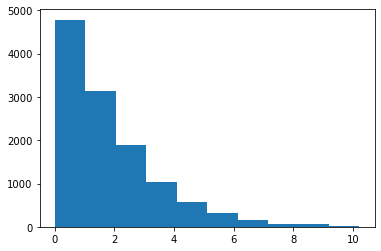

In [8]:
plt.hist(np.log1p(train_df['likes']));

## Preprocessing

In [9]:
principal_maker_occupation_group = principal_maker_occupation.groupby('id')['name'].apply(list).apply('_'.join).reset_index()
principal_maker_occupation_group = principal_maker_occupation_group.rename(columns={'name':'occupation'})

In [10]:
principal_maker = principal_maker.merge(principal_maker_occupation_group,on='id',how='left')
principal_maker.fillna('none',inplace=True)

In [11]:
principal_maker_qualification_group = principal_maker.groupby('object_id')['qualification'].apply(list).reset_index()
principal_maker_qualification_group

,object_id,qualification
0,000405d9a5e3f49fc49d,[mentioned on object]
1,001020bd00b149970f78,[workshop of]
2,0011d6be41612ec9eae3,[none]
3,0012765f7a97ccc3e9e9,[attributed to]
4,00133be3ff222c9b74b0,[none]
...,...,...
24029,fff4bbb55fd7702d294e,[none]
24030,fffbe07b997bec00e203,[attributed to]
24031,fffd1675758205748d7f,[none]
24032,fffd43b134ba7197d890,[none]


In [12]:
principal_maker_roles_group = principal_maker.groupby('object_id')['roles'].apply(list).reset_index()
principal_maker_roles_group

,object_id,roles
0,000405d9a5e3f49fc49d,[none]
1,001020bd00b149970f78,[painter]
2,0011d6be41612ec9eae3,[painter]
3,0012765f7a97ccc3e9e9,[none]
4,00133be3ff222c9b74b0,[print maker]
...,...,...
24029,fff4bbb55fd7702d294e,[none]
24030,fffbe07b997bec00e203,[none]
24031,fffd1675758205748d7f,[none]
24032,fffd43b134ba7197d890,[none]


In [13]:
principal_maker_occupation_group = principal_maker.groupby('object_id')['occupation'].apply(list).reset_index()
principal_maker_occupation_group

,object_id,occupation
0,000405d9a5e3f49fc49d,[none]
1,001020bd00b149970f78,[draughtsman_painter]
2,0011d6be41612ec9eae3,[print maker_draughtsman_painter]
3,0012765f7a97ccc3e9e9,[none]
4,00133be3ff222c9b74b0,[print maker]
...,...,...
24029,fff4bbb55fd7702d294e,[none]
24030,fffbe07b997bec00e203,[none]
24031,fffd1675758205748d7f,[publisher]
24032,fffd43b134ba7197d890,[none]


In [14]:
train_len = len(train_df)
test_len = len(test_df)
y = np.log1p(train_df["likes"])

In [15]:
cols = test_df.columns.to_list()
cat_cols = ['art_series_id','principal_maker', 'principal_or_first_maker','copyright_holder','acquisition_method','acquisition_credit_line']

for c in cat_cols:
    train_df.loc[~train_df[c].isin(test_df[c].unique()),c] = np.nan
    test_df.loc[~test_df[c].isin(train_df[c].unique()),c] = np.nan

train_df = pd.concat([train_df[cols],test_df[cols]]).reset_index(drop=True)

train_df["title_lang"] = train_df["title"].fillna("").map(lambda x: cld2.detect(x)[2][0][1])

cat_cols = ['title_lang','art_series_id','principal_maker', 'principal_or_first_maker',
'copyright_holder','acquisition_method','acquisition_credit_line']

for c in cat_cols:
    train_df[c] = train_df[c].astype(str)
    le = LabelEncoder()
    train_df[c] = le.fit_transform(train_df[c])

In [16]:
for axis in ['h', 'w', 't', 'd']:
    column_name = f'size_{axis}'
    size_info = train_df['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis)) # 正規表現を使ってサイズを抽出
    size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
    size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float) # dtypeがobjectになってるのでfloatに直す
    #単位をmmに統一する
    size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) 
    train_df[column_name] = size_info[column_name] # trainにくっつける

In [17]:
# Area = height x width
train_df['size_hw'] = train_df['size_h']*train_df['size_w']

In [18]:
# 作成期間
train_df['make_bitween'] = train_df['dating_year_late'] - train_df['dating_year_early']

In [19]:
# 説明の長さ
train_df['descrip_len'] = train_df['description'].apply(lambda x: description_length(x))

In [20]:
# 総合特徴量
detail = pd.concat([material,collection,technique,hist_person,production_place], axis=0).reset_index(drop=True)

n_iter = 100
model_size = 10

detail_group = detail.groupby('object_id')['name'].apply(list).reset_index()

# Word2Vecの学習
w2v_model = word2vec.Word2Vec(detail_group["name"].values.tolist(),size=model_size,min_count=1,window=1,iter=n_iter)

# 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって特徴量ベクトルにする
sentence_vectors = detail_group["name"].apply(lambda x: np.mean([w2v_model.wv[e] for e in x], axis=0))
sentence_vectors = np.vstack([x for x in sentence_vectors])
sentence_vector_df = pd.DataFrame(sentence_vectors,columns=[f"w2v_{i}" for i in range(model_size)])
sentence_vector_df.index = detail_group["object_id"]

In [21]:
# Material
n_iter = 100
model_size_m = 5

material_group = material.groupby('object_id')['name'].apply(list).reset_index()

# Word2Vecの学習
w2v_model_m = word2vec.Word2Vec(material_group['name'].values.tolist(),size=model_size_m,min_count=1,window=1,iter=n_iter)

# 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって特徴量ベクトルにする
material_vectors = material_group['name'].apply(lambda x: np.mean([w2v_model_m.wv[e] for e in x], axis=0))
material_vectors = np.vstack([x for x in material_vectors])
material_vector_df = pd.DataFrame(material_vectors,columns=[f"w2v_{i}_m" for i in range(model_size_m)])
material_vector_df.index = material_group["object_id"]

In [22]:
# Technique
n_iter = 100
model_size_tec = 5

technique_group = technique.groupby('object_id')['name'].apply(list).reset_index()

# Word2Vecの学習
w2v_model_tec = word2vec.Word2Vec(technique_group['name'].values.tolist(),size=model_size_tec,min_count=1,window=1,iter=n_iter)

# 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって特徴量ベクトルにする
technique_vectors = technique_group['name'].apply(lambda x: np.mean([w2v_model_tec.wv[e] for e in x], axis=0))
technique_vectors = np.vstack([x for x in technique_vectors])
technique_vector_df = pd.DataFrame(technique_vectors,columns=[f"w2v_{i}_tec" for i in range(model_size_tec)])
technique_vector_df.index = technique_group["object_id"]

In [23]:
# production_place
n_iter = 100
model_size_place = 5

production_place_group = production_place.groupby('object_id')['name'].apply(list).reset_index()

# Word2Vecの学習
w2v_model_place = word2vec.Word2Vec(production_place_group['name'].values.tolist(),size=model_size_place,min_count=1,window=1,iter=n_iter)

# 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって特徴量ベクトルにする
production_place_vectors = production_place_group['name'].apply(lambda x: np.mean([w2v_model_place.wv[e] for e in x], axis=0))
production_place_vectors = np.vstack([x for x in production_place_vectors])
production_place_vector_df = pd.DataFrame(production_place_vectors,columns=[f"w2v_{i}_place" for i in range(model_size_place)])
production_place_vector_df.index = production_place_group["object_id"]

In [24]:
# Color
n_iter = 100
model_size_c = 10

color_group = color.groupby('object_id')['hex'].apply(list).reset_index()

# Word2Vecの学習
w2v_model_c = word2vec.Word2Vec(color_group['hex'].values.tolist(),size=model_size_c,min_count=1,window=1,iter=n_iter)

# 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって特徴量ベクトルにする
color_vectors = color_group['hex'].apply(lambda x: np.mean([w2v_model_c.wv[e] for e in x], axis=0))
color_vectors = np.vstack([x for x in color_vectors])
color_vector_df = pd.DataFrame(color_vectors,columns=[f"w2v_{i}_c" for i in range(model_size_c)])
color_vector_df.index = color_group["object_id"]

In [25]:
# HistPerson
n_iter = 100
model_size_p = 10

hist_person_group = hist_person.groupby("object_id")["name"].apply(list).reset_index()

# Word2Vecの学習
w2v_model_p = word2vec.Word2Vec(detail_group["name"].values.tolist(),size=model_size_p,min_count=1,window=1,iter=n_iter)

# 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって特徴量ベクトルにする
hist_vectors = hist_person_group["name"].apply(lambda x: np.mean([w2v_model_p.wv[e] for e in x], axis=0))
hist_vectors = np.vstack([x for x in hist_vectors])
hist_vector_df = pd.DataFrame(hist_vectors,columns=[f"w2v_{i}_p" for i in range(model_size_p)])
hist_vector_df.index = hist_person_group["object_id"]

In [26]:
# Title
n_iter = 100
model_size_t = 10

title_group = train_df[['object_id','title']]
title_group['title'] = title_group['title'].apply(lambda x: title_split(x))

# Word2Vecの学習
w2v_model_t = word2vec.Word2Vec(title_group['title'].values.tolist(),size=model_size_t,min_count=1,window=1,iter=n_iter)

# 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって特徴量ベクトルにする
title_vectors = title_group['title'].apply(lambda x: np.mean([w2v_model_t.wv[e] for e in x], axis=0))
title_vectors = np.vstack([x for x in title_vectors])
title_vector_df = pd.DataFrame(title_vectors,columns=[f"w2v_{i}_t" for i in range(model_size_t)])
title_vector_df.index = title_group["object_id"]

In [27]:
# Discription
n_iter = 100
model_size_d = 10

description_group = train_df[['object_id','description']]
description_group['description'] = description_group['description'].fillna('Nonedescription')
description_group['description'] = description_group['description'].apply(lambda x: title_split(x))

# Word2Vecの学習
w2v_model_d = word2vec.Word2Vec(description_group['description'].values.tolist(),size=model_size_d,min_count=1,window=1,iter=n_iter)

# 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって特徴量ベクトルにする
description_vectors = description_group['description'].apply(lambda x: np.mean([w2v_model_d.wv[e] for e in x], axis=0))
description_vectors = np.vstack([x for x in description_vectors])
description_vector_df = pd.DataFrame(description_vectors,columns=[f"w2v_{i}_d" for i in range(model_size_d)])
description_vector_df.index = description_group["object_id"]

In [28]:
# Qualification
n_iter = 100
model_size_q = 5

# Word2Vecの学習
w2v_model_q = word2vec.Word2Vec(principal_maker_qualification_group['qualification'].values.tolist(),size=model_size_q,min_count=1,window=1,iter=n_iter)

# 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって特徴量ベクトルにする
qualification_vectors = principal_maker_qualification_group['qualification'].apply(lambda x: np.mean([w2v_model_q.wv[e] for e in x], axis=0))
qualification_vectors = np.vstack([x for x in qualification_vectors])
qualification_vector_df = pd.DataFrame(qualification_vectors,columns=[f"w2v_{i}_q" for i in range(model_size_q)])
qualification_vector_df.index = principal_maker_qualification_group["object_id"]

In [29]:
# Roles
n_iter = 100
model_size_r = 5

# Word2Vecの学習
w2v_model_r = word2vec.Word2Vec(principal_maker_roles_group['roles'].values.tolist(),size=model_size_r,min_count=1,window=1,iter=n_iter)

# 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって特徴量ベクトルにする
roles_vectors = principal_maker_roles_group['roles'].apply(lambda x: np.mean([w2v_model_r.wv[e] for e in x], axis=0))
roles_vectors = np.vstack([x for x in roles_vectors])
roles_vector_df = pd.DataFrame(roles_vectors,columns=[f"w2v_{i}_r" for i in range(model_size_r)])
roles_vector_df.index = principal_maker_roles_group["object_id"]

In [30]:
# Occupation
n_iter = 100
model_size_o = 5

# Word2Vecの学習
w2v_model_o = word2vec.Word2Vec(principal_maker_occupation_group['occupation'].values.tolist(),size=model_size_o,min_count=1,window=1,iter=n_iter)

# 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって特徴量ベクトルにする
occupation_vectors = principal_maker_occupation_group['occupation'].apply(lambda x: np.mean([w2v_model_o.wv[e] for e in x], axis=0))
occupation_vectors = np.vstack([x for x in occupation_vectors])
occupation_vector_df = pd.DataFrame(occupation_vectors,columns=[f"w2v_{i}_o" for i in range(model_size_o)])
occupation_vector_df.index = principal_maker_occupation_group["object_id"]

In [31]:
hist_person_group = hist_person.groupby("object_id")["name"].apply(list)

In [32]:
hist_count = hist_person_group.apply(lambda x: count_fe(x))

In [33]:
palette['color'] = \
    palette['ratio']*(np.sqrt(palette['color_r']**2 +palette['color_g']**2 +palette['color_b']**2))

palette['color_rb'] = \
    palette['ratio']*(np.sqrt(palette['color_r']**2-palette['color_b']**2))

palette['color_rg'] = \
    palette['ratio']*(np.sqrt(palette['color_r']**2-palette['color_g']**2))

palette['color_gb'] = \
    palette['ratio']*(np.sqrt(palette['color_g']**2-palette['color_b']**2))

In [34]:
palette_group = palette.groupby("object_id").agg(['sum','mean','median','var','std',])

In [35]:
train_merge = train_df.merge(hist_count,on='object_id',how='left')
print(len(train_merge))
train_merge = train_merge.merge(palette_group,on='object_id',how='left')
print(len(train_merge))
train_merge = train_merge.merge(sentence_vector_df,on='object_id',how='left')
print(len(train_merge))
train_merge = train_merge.merge(color_vector_df,on='object_id',how='left')
print(len(train_merge))
train_merge = train_merge.merge(hist_vector_df,on='object_id',how='left')
print(len(train_merge))
train_merge = train_merge.merge(title_vector_df,on='object_id',how='left')
print(len(train_merge))
train_merge = train_merge.merge(description_vector_df,on='object_id',how='left')
print(len(train_merge))
train_merge = train_merge.merge(material_vector_df,on='object_id',how='left')
print(len(train_merge))
train_merge = train_merge.merge(technique_vector_df,on='object_id',how='left')
print(len(train_merge))
train_merge = train_merge.merge(production_place_vector_df,on='object_id',how='left')
print(len(train_merge))
train_merge = train_merge.merge(qualification_vector_df,on='object_id',how='left')
print(len(train_merge))
train_merge = train_merge.merge(roles_vector_df,on='object_id',how='left')
print(len(train_merge))
train_merge = train_merge.merge(occupation_vector_df,on='object_id',how='left')
print(len(train_merge))

24034
24034
24034
24034
24034
24034
24034
24034
24034
24034
24034
24034
24034


In [36]:
w2v_feature = [f'w2v_{i}' for i in range(model_size)]
w2v_c_feature = [f'w2v_{i}_c' for i in range(model_size_c)]
w2v_p_feature = [f'w2v_{i}_p' for i in range(model_size_p)]
w2v_t_feature = [f'w2v_{i}_t' for i in range(model_size_t)]
w2v_d_feature = [f'w2v_{i}_d' for i in range(model_size_d)]
w2v_m_feature = [f'w2v_{i}_m' for i in range(model_size_m)]
w2v_tec_feature = [f'w2v_{i}_tec' for i in range(model_size_tec)]
w2v_place_feature = [f'w2v_{i}_place' for i in range(model_size_place)]
w2v_q_feature = [f'w2v_{i}_q' for i in range(model_size_q)]
w2v_r_feature = [f'w2v_{i}_r' for i in range(model_size_r)]
w2v_o_feature = [f'w2v_{i}_o' for i in range(model_size_o)]

features = list(train_merge.columns) + w2v_feature + w2v_c_feature + w2v_p_feature + w2v_t_feature + w2v_d_feature + w2v_m_feature \
    + w2v_tec_feature + w2v_place_feature + w2v_q_feature + w2v_r_feature + w2v_o_feature

drop_cols = ['object_id', 'title', 'description', 'long_title', 'sub_title', 'more_title', 'acquisition_date', 'dating_presenting_date']

features = [i for i in features if i not in drop_cols]
categorical_features = ['art_series_id','principal_maker', 'principal_or_first_maker','copyright_holder','acquisition_method','acquisition_credit_line']

In [37]:
test = train_merge.iloc[train_len:].reset_index(drop=True)
train = train_merge.iloc[:train_len].reset_index(drop=True)

In [38]:
print('train.shape',train.shape)
print('test.shape',test.shape)

train.shape (12026, 147)
test.shape (12008, 147)


## Training

In [39]:
y_oof = np.empty([len(train),])
y_test = []
feature_importances = pd.DataFrame()
models = []

kf = KFold(n_splits=N_SPLITS,random_state=SEED, shuffle=SHUFFLE)
for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
    print('Fold {}'.format(fold + 1))
    x_train, y_train = train.iloc[train_idx][features], y.iloc[train_idx]
    x_val, y_val = train.iloc[valid_idx][features], y.iloc[valid_idx]

    if TRAIN:
        y_pred_valid, y_pred_test, valid_loss, importances, best_iter, model = \
            train_lgbm(
                x_train, y_train, x_val, y_val, test[features],
                categorical_features = categorical_features,
                fold_id = fold,
                lgb_params = LGBM_PARAMS,
                fit_params = LGBM_FIT_PARAMS,
                loss_func = calc_loss,
                calc_importances=True
            )

        models.append(model)    
        model.save_model(f'exp{EXP}_model_fold{fold + 1}.txt')

        y_oof[valid_idx] = y_pred_valid
        score = calc_loss(y[valid_idx], y_pred_valid)
        y_test.append(y_pred_test)
        feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)
    
score = calc_loss(y, y_oof)
print('SCORE:', score)

Fold 1
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1.28253	valid_1's rmse: 1.40982
[200]	training's rmse: 1.00648	valid_1's rmse: 1.2104
[300]	training's rmse: 0.837346	valid_1's rmse: 1.11933
[400]	training's rmse: 0.724557	valid_1's rmse: 1.07949
[500]	training's rmse: 0.643338	valid_1's rmse: 1.0614
[600]	training's rmse: 0.57959	valid_1's rmse: 1.05043
[700]	training's rmse: 0.526464	valid_1's rmse: 1.04504
[800]	training's rmse: 0.480377	valid_1's rmse: 1.04092
[900]	training's rmse: 0.439925	valid_1's rmse: 1.03801
[1000]	training's rmse: 0.403684	valid_1's rmse: 1.03639
[1100]	training's rmse: 0.371634	valid_1's rmse: 1.03507
[1200]	training's rmse: 0.342438	valid_1's rmse: 1.03392
[1300]	training's rmse: 0.316607	valid_1's rmse: 1.03299
[1400]	training's rmse: 0.292947	valid_1's rmse: 1.03238
[1500]	training's rmse: 0.271742	valid_1's rmse: 1.03215
[1600]	training's rmse: 0.252477	valid_1's rmse: 1.03176
[1700]	training's rmse: 0.23457	va

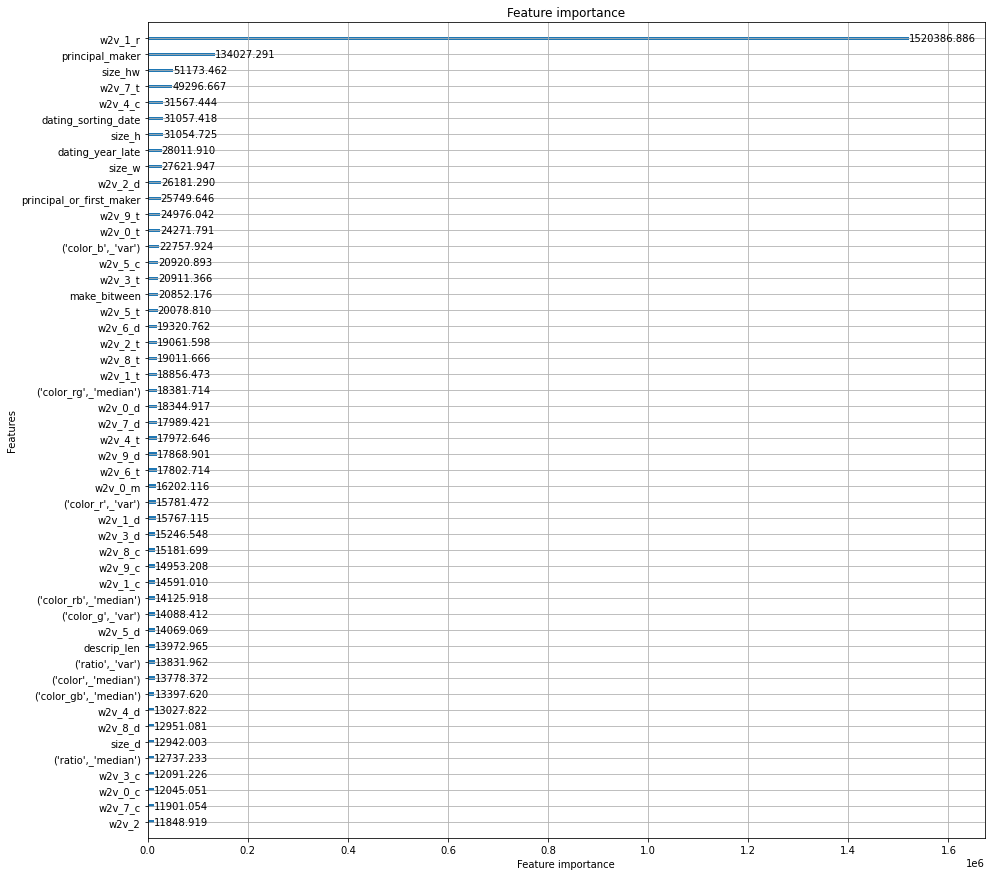

In [40]:
if TRAIN:
    fig,ax = plt.subplots(figsize=(15,15))
    lgb.plot_importance(model, ax=ax,importance_type='gain',max_num_features=50)
    plt.show();

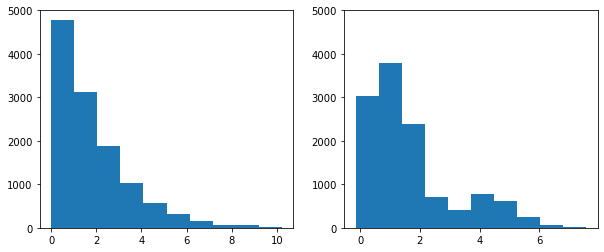

In [41]:
# CV check
if TRAIN:
    fig = plt.figure(figsize=(10,4))

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.hist(y)
    ax2.hist(y_oof)
    ax1.set_ylim(0,5000)
    ax2.set_ylim(0,5000);

## Inference

In [43]:
# submission
y_test = y_test[2]
y_test_sub =  np.mean(y_test,axis=0)
y_test_sub = np.expm1(y_test_sub)

sub = pd.read_csv(SUB_PATH)
sub["likes"] = y_test_sub
sub.loc[sub.likes <= 0,"likes"] = 0

sub.to_csv(SAVE_TEST_SUB_PATH,index=False)